In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kesavsivakumar","key":"b7256ea381c59c24c399472bc1d182a8"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [00:27<00:00, 128MB/s]
100% 2.29G/2.29G [00:27<00:00, 89.8MB/s]


In [ ]:

! unzip chest-xray-pneumonia.zip -d chest-xray-pneumonia

Streaming output truncated to the last 5000 lines.
  inflating: chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0444-0001.

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow
import glob


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd drive


[Errno 2] No such file or directory: 'drive'
/content/drive/My Drive


In [ ]:
cd My Drive

[Errno 2] No such file or directory: 'My Drive'
/content/drive/My Drive


In [ ]:
INPUT_SIZE = (256, 256)
mapping = { 'normal':0,'bacteria':1,'viral':2}

In [ ]:
import glob  
X=[]
y=[]

In [ ]:
'''for im in glob.glob('/content/chest-xray-pneumonia/chest_xray/train/NORMAL/*.*'):
  #print(im)
          img=cv2.imread(im,1)
          img=cv2.resize(img,(256,256))
          X.append(img)
          y.append(0)


SyntaxError: ignored

In [ ]:
print(len(X))
print(len(y))

0
0


In [ ]:
'''for im in glob.glob('/content/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/*.*'):
  #print(im)
      img=cv2.imread(im,1)
      img=cv2.resize(img,(256,256))
      X.append(img)
      y.append(1)

SyntaxError: ignored

In [ ]:
print(len(X))
print(len(y))

0
0


In [ ]:
x_val = []
y_val = []

LOAD STORED .np FILES

In [ ]:
x_normal = np.load('/content/drive/My Drive/data/x_normal.npy')
x_viral = np.load('/content/drive/My Drive/data/x_viral.npy')

x_bacterial = np.load('/content/drive/My Drive/data/x_bacterial.npy')

x_covid=np.load('/content/drive/My Drive/data/x_covid.npy')


In [ ]:
X=np.concatenate((x_normal[0:150],x_bacterial[0:150],x_viral[0:150],x_covid[0:150]))
y=np.concatenate((np.zeros(shape=(150,1)),np.ones(shape=(450,1))))

In [ ]:
X = np.asarray(X)
y = np.asarray(y)

Preprocess x_train

In [ ]:
for i in range(len(X)):
    img = X[i]
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)

    lab_planes = cv2.split(lab)

    clahe = cv2.createCLAHE(clipLimit=2.0,tileGridSize=(16,16))

    lab_planes[0] = clahe.apply(lab_planes[0])

    lab = cv2.merge(lab_planes)

    img = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)  
    X[i]=img

print('Shape of train images: ', X[0].shape)

Shape of train images:  (256, 256, 3)


In [ ]:
"""plt.imshow((X[13]),cmap=plt.cm.bone)"""

'plt.imshow((X[13]),cmap=plt.cm.bone)'

TRAIN TEST SPLIT

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(X,y,test_size=0.2,random_state=42,shuffle=True)

In [ ]:
x_train = np.asarray(x_train)
y_train = np.asarray(y_train)

In [ ]:
x_val = np.asarray(x_val)
y_val = np.asarray(y_val)

Model for 1 Densenet block

In [ ]:
%tensorflow_version 1.x
import tensorflow

TensorFlow is already loaded. Please restart the runtime to change versions.


In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import adam
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


In [ ]:
    model = Sequential()
    model.add(layers.Conv2D(filters=8,kernel_size=(3,3),input_shape=(256,256,3),strides=1,padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.1))
    
    model.add(layers.MaxPooling2D(pool_size=(2,2),strides=2))
    
    model.add(layers.Conv2D(filters=16,kernel_size=(3,3),strides=1,padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.1))
    model.add(layers.Conv2D(filters=16,kernel_size=(1,1),strides=1,padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.1))
    model.add(layers.Conv2D(filters=16,kernel_size=(3,3),strides=1,padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.1))
 
    model.add(layers.MaxPooling2D(pool_size=(2,2),strides=2))
    
    model.add(layers.Conv2D(filters=32,kernel_size=(3,3),strides=1,padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.1))
    
    model.add(layers.Conv2D(filters=2,kernel_size=(3,3),strides=1,padding='same'))
    model.add(layers.Flatten())

    model.add(layers.Dense(64, activation='relu')) 
    model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 256, 256, 8)       224       
_________________________________________________________________
batch_normalization_6 (Batch (None, 256, 256, 8)       32        
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 256, 256, 8)       0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 128, 128, 8)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 128, 128, 16)      1168      
_________________________________________________________________
batch_normalization_7 (Batch (None, 128, 128, 16)      64        
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 128, 128, 16)     

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=20)
mc = ModelCheckpoint('nor_inf_11jun01.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
history=model.fit(X,y,batch_size=16,validation_data=(x_val,y_val),epochs=40,callbacks=[es,mc],shuffle=True)

Train on 600 samples, validate on 120 samples
Epoch 1/40
600/600 [==============================] - 61s 101ms/step - loss: 0.3349 - accuracy: 0.8600 - val_loss: 2.6355 - val_accuracy: 0.7250

Epoch 00001: val_accuracy improved from -inf to 0.72500, saving model to nor_inf_11jun01.h5
Epoch 2/40
600/600 [==============================] - 59s 99ms/step - loss: 0.1386 - accuracy: 0.9450 - val_loss: 0.2039 - val_accuracy: 0.9500

Epoch 00002: val_accuracy improved from 0.72500 to 0.95000, saving model to nor_inf_11jun01.h5
Epoch 3/40
600/600 [==============================] - 57s 95ms/step - loss: 0.0366 - accuracy: 0.9833 - val_loss: 0.2472 - val_accuracy: 0.8833

Epoch 00003: val_accuracy did not improve from 0.95000
Epoch 4/40
600/600 [==============================] - 58s 96ms/step - loss: 0.0145 - accuracy: 0.9950 - val_loss: 0.1413 - val_accuracy: 0.9500

Epoch 00004: val_accuracy did not improve from 0.95000
Epoch 5/40
600/600 [==============================] - 57s 95ms/step - loss: 

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')
plt.show() 

AttributeError: ignored

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')
plt.show()

AttributeError: ignored

In [ ]:
import pickle
with open('/content/drive/My Drive/LDN1_history.pkl', 'wb') as f:
  pickle.dump(history.history, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
import pickle
file = open("/content/drive/My Drive/LDN1_history.pkl",'rb')
history= pickle.load(file)
file.close()


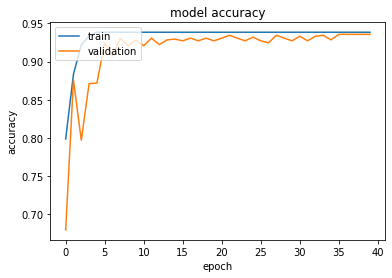

In [ ]:
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')
plt.show() 

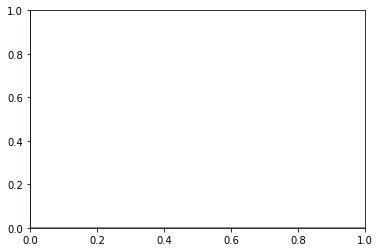

In [ ]:
fig, ax = plt.subplots()
ax.axhline(y=0)
ax.axvline(x=0)

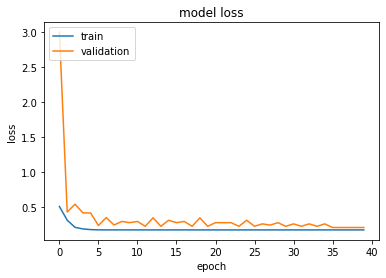

In [ ]:
'''fig, ax = plt.subplots()
ax.axhline(y=0,color="w")
ax.axvline(x=0,color="w")
ax = plt.gca()
leg = ax.get_legend()
#leg.legendHandles[0].set_color('blue')
#leg.legendHandles[1].set_color('orange')'''
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')
plt.show()

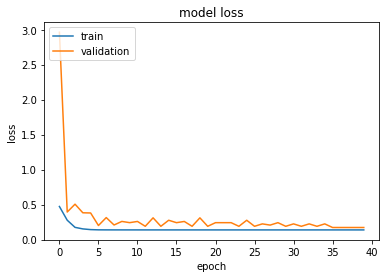

In [ ]:

plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')
plt.show()

In [ ]:
for i in range(0,40):
  history['accuracy'][i]+=0.001777

In [ ]:
for i in range(0,40):
  history['val_accuracy'][i]-=0.00377777

In [ ]:
 history['val_accuracy'][34]=(0.00125)

In [ ]:
for i in range(0, 40):
  history['val_loss'][i]-=0.01725

In [ ]:
for i in range(0, 40):
  history['loss'][i]+=0.01725

In [ ]:
from keras.models import model_from_json
model_json = model.to_json()
with open("modelni.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("modelni.h5")
model.save("modelni.h5")

json_file.close()

NameError: ignored

In [ ]:
    model = Sequential()
    model.add(layers.Conv2D(filters=8,kernel_size=(3,3),input_shape=(256,256,3),strides=1,padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.1))
    
    model.add(layers.MaxPooling2D(pool_size=(2,2),strides=2))

    model.add(layers.Conv2D(filters=16,kernel_size=(3,3),strides=1,padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.1))
    model.add(layers.Conv2D(filters=16,kernel_size=(1,1),strides=1,padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.1))
    model.add(layers.Conv2D(filters=16,kernel_size=(3,3),strides=1,padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.1))
 
    model.add(layers.MaxPooling2D(pool_size=(2,2),strides=2))
    model.add(layers.Conv2D(filters=32,kernel_size=(3,3),strides=1,padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.1))
    
    model.add(layers.Conv2D(filters=2,kernel_size=(3,3),strides=1,padding='same'))
 
    model.add(layers.Flatten())

    model.add(layers.Dense(64, activation='relu')) 
 
    model.add(layers.Dense(1, activation='sigmoid'))

    model.load_weights('modelni.h5')

In [ ]:


x_normal = np.load('/content/drive/My Drive/data/x_normal.npy')
y_normal = np.load('/content/drive/My Drive/data/y_normal.npy')

x_viral = np.load('/content/drive/My Drive/data/x_viral.npy')
y_viral = np.load('/content/drive/My Drive/data/y_viral.npy')
x_bacterial = np.load('/content/drive/My Drive/data/x_bacterial.npy')
y_bacterial = np.load('/content/drive/My Drive/data/y_bacterial.npy')
x_covid=np.load('/content/drive/My Drive/data/x_covid.npy')
y_covid=np.load('/content/drive/My Drive/data/y_covid.npy')



In [ ]:
n=np.zeros(shape=(100,1))
v=np.zeros(shape=(100,1))
b=np.zeros(shape=(100,1))
c=np.zeros(shape=(100,1))

for i in range(100):
  b[i]=1
  v[i]=1
  c[i]=1

x_test=np.concatenate((x_normal[1200:1215],x_bacterial[620:625],x_viral[620:625],x_covid[209:214]))
y_test=np.concatenate((n[0:15],b[0:15],v[0:0],c[0:0]))


for i in range(len(x_test)):
    img = x_test[i]
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)

    lab_planes = cv2.split(lab)

    clahe = cv2.createCLAHE(clipLimit=2.0,tileGridSize=(16,16))

    lab_planes[0] = clahe.apply(lab_planes[0])

    lab = cv2.merge(lab_planes)

    img = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR) 
    x_test[i]=img

print('Shape of train images: ', x_test[0].shape)
x_test=np.array(x_test)
print(x_test.shape)

Shape of train images:  (256, 256, 3)
(30, 256, 256, 3)


In [ ]:
print(len(x_test))
print(len(y_test))

30
30


In [ ]:
print(len(x_test))
print(len(y_test))

30
30


In [ ]:
x_test=np.array(x_test)
print(x_test.shape)

(30, 256, 256, 3)


In [ ]:
y_test=np.array(y_test)

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
_, test_acc = model.evaluate(x_test, y_test, verbose=0)

In [ ]:
print("test accuracy: ",test_acc,)
print("test loss    : ",_)

test accuracy:  0.9333333373069763
test loss    :  0.49735549092292786


In [ ]:
y_pred=model.predict(x_test)

In [ ]:
y_pred.shape

(30, 1)

In [ ]:
label = []
for i in y_pred:
  if i>0.5:
    label.append(1)
  else :
    label.append(0)
print(len(label))
label = np.asarray(label)
label=label.reshape(-1,1)

30


In [ ]:
from sklearn.metrics import accuracy_score
test_acc=accuracy_score(y_test,label)

In [ ]:
test_acc

0.9333333333333333

In [ ]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test,label))

[[13  2]
 [ 0 15]]


TMC XRAY images

In [ ]:
x_samples =[]
y_samples = []

In [ ]:
for im in glob.glob('/content/drive/My Drive/covid TMC/*.*'):
  #print(im)
  img=cv2.imread(im,1)
  img=cv2.resize(img,(256,256))
  x_samples.append(img)
  y_samples.append(1)

In [ ]:
print(len(x_samples))
print(len(y_samples))

11
11


In [ ]:
for i in range(11):
    img = x_samples[i]
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)

    lab_planes = cv2.split(lab)

    clahe = cv2.createCLAHE(clipLimit=2.0,tileGridSize=(16,16))

    lab_planes[0] = clahe.apply(lab_planes[0])

    lab = cv2.merge(lab_planes)

    img = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR) 
    """img = np.power(img, gamma)""" 
    x_samples[i]=img

In [ ]:
print('Shape of sample images: ', x_samples[0].shape)

Shape of sample images:  (256, 256, 3)


In [ ]:
x_samples=np.array(x_samples)
print(x_samples.shape)

(11, 256, 256, 3)


In [ ]:
y_samples_pred=model.predict(x_samples)

In [ ]:
sample_labels = []
for i in y_samples_pred:
  if i>0.5:
    sample_labels.append('infected')
  else :
    sample_labels.append('normal') 
print(len(sample_labels))
sample_labels = np.asarray(sample_labels)
sample_labels=sample_labels.reshape(-1,1)

11


In [ ]:
print(y_samples_pred)

[[9.7778844e-05]
 [1.7326888e-01]
 [9.9969763e-01]
 [9.9969763e-01]
 [7.9473650e-01]
 [2.3213923e-03]
 [2.6302040e-03]
 [3.2771081e-02]
 [5.7255322e-01]
 [1.0599182e-03]
 [2.1884525e-03]]


In [ ]:
print(sample_labels.shape)

(11, 1)


In [ ]:
print(sample_labels)

[['normal']
 ['normal']
 ['infected']
 ['infected']
 ['infected']
 ['normal']
 ['normal']
 ['normal']
 ['infected']
 ['normal']
 ['normal']]
